# **Q1**

In [11]:
# !pip install yfinance -q

     |████████████████████████████████| 6.4 MB 11.9 MB/s 


In [40]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd

In [174]:
train_data = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
test_data = yf.download("BTC-USD", start="2021-09-02", end="2021-12-26")

train_data.shape, test_data.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((2542, 6), (116, 6))

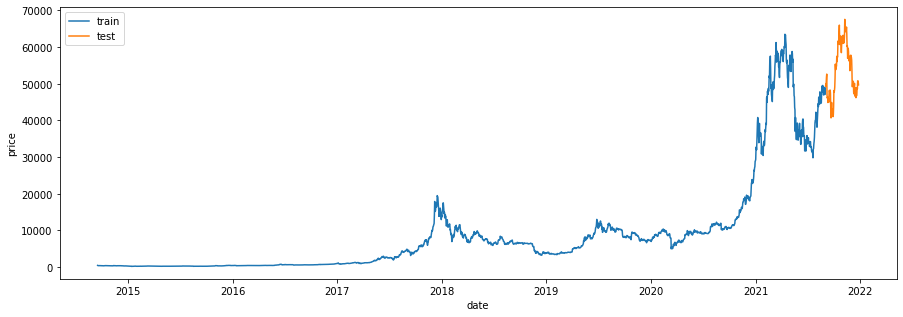

In [175]:
plt.figure(figsize=(15,5))

plt.plot(train_data.Close)
plt.plot(test_data.Close)

plt.ylabel('price')
plt.xlabel('date')
plt.legend(['train', 'test'])

In [42]:
train_data = train_data.Close.values.reshape(-1, 1)
test_data = test_data.Close.values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(train_data)

train_normalized = scaler.fit_transform(train_data)
test_normalized = scaler.fit_transform(test_data)

train_normalized.shape, test_normalized.shape

((2542, 1), (116, 1))

In [164]:
threshold = 60

x_train = np.array([train_normalized[i - threshold : i] for i in range(threshold, train_normalized.shape[0])])
y_train = np.array([train_normalized[i][0] for i in range(threshold, train_normalized.shape[0])])

train_test = np.concatenate((train_normalized, test_normalized))
x_test = np.array([train_test[i - threshold : i] for i in range(train_normalized.shape[0], train_test.shape[0])])
y_test = np.array([train_test[i][0] for i in range(train_normalized.shape[0], train_test.shape[0])])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2482, 60, 1), (2482,), (116, 60, 1), (116,))

In [68]:
def build_model(name):
    model = tf.keras.models.Sequential(
        name=name, 
        layers= [tf.keras.layers.Input((60, 1)),
                 tf.keras.layers.LSTM(units=50, return_sequences=True),
                 tf.keras.layers.Dropout(0.2),
                 tf.keras.layers.LSTM(units=50, return_sequences=True),
                 tf.keras.layers.Dropout(0.2),
                 tf.keras.layers.LSTM(units=50, return_sequences=True),
                 tf.keras.layers.Dropout(0.2),
                 tf.keras.layers.LSTM(units=50, return_sequences=False),
                 tf.keras.layers.Dense(units=1)])
    return model
    
model = build_model('q1')

In [69]:
model.summary()

Model: "q1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200    

In [74]:
model.compile('adam', 'mean_squared_error')
model.fit(x_train, y_train, 32, 100)

Epoch 1/100
78/78 [==============================] - 41s 60ms/step - loss: 4.0927e-04
Epoch 2/100
78/78 [==============================] - 5s 60ms/step - loss: 3.0578e-04
Epoch 3/100
78/78 [==============================] - 5s 60ms/step - loss: 3.8173e-04
Epoch 4/100
78/78 [==============================] - 5s 60ms/step - loss: 3.6366e-04
Epoch 5/100
78/78 [==============================] - 5s 59ms/step - loss: 3.1475e-04
Epoch 6/100
78/78 [==============================] - 5s 60ms/step - loss: 3.6607e-04
Epoch 7/100
78/78 [==============================] - 5s 60ms/step - loss: 2.6903e-04
Epoch 8/100
78/78 [==============================] - 5s 60ms/step - loss: 3.3671e-04
Epoch 9/100
78/78 [==============================] - 5s 60ms/step - loss: 3.4422e-04
Epoch 10/100
78/78 [==============================] - 5s 60ms/step - loss: 3.1079e-04
Epoch 11/100
78/78 [==============================] - 5s 60ms/step - loss: 3.0431e-04
Epoch 12/100
78/78 [==============================] - 5s 59ms/

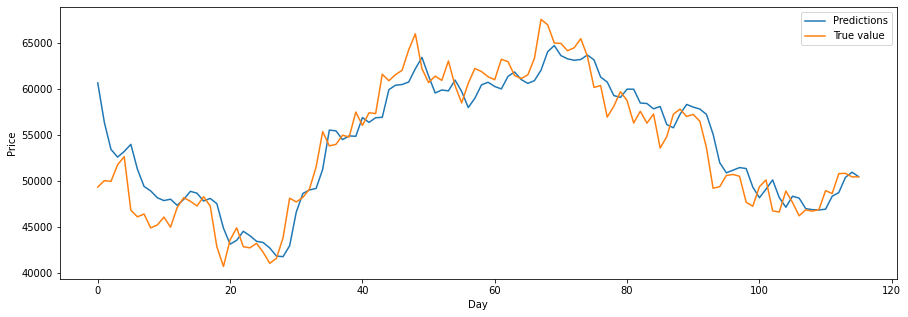

In [170]:
prediction = model.predict(x_test)

plt.figure(figsize=(15,5))

plt.plot(np.squeeze(scaler.inverse_transform(prediction)))
plt.plot(np.squeeze(scaler.inverse_transform([y_test])))
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(["Predictions", "True value"])

In [156]:
future_pred = test_normalized.copy()
for i in range(90):
    x_future = future_pred[future_pred.shape[0] - 60:].T
    x_future = np.expand_dims(x_future, axis=2)
    pred = model.predict(x_future)
    future_pred = np.concatenate((future_pred, pred))

Text(0, 0.5, 'Price')

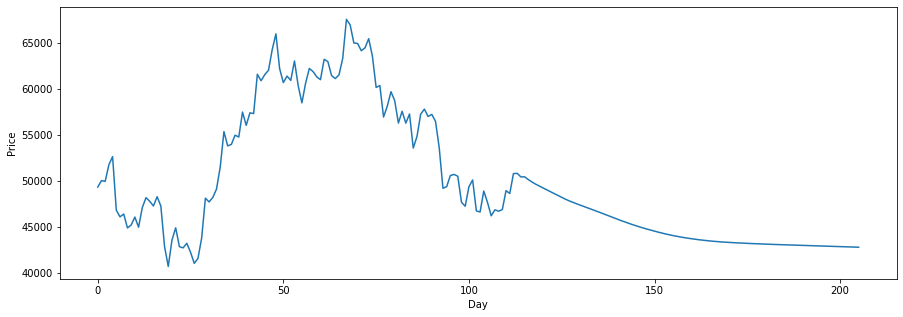

In [171]:
plt.figure(figsize=(15,5))

plt.plot(np.squeeze(scaler.inverse_transform(future_pred)))
plt.xlabel('Day')
plt.ylabel('Price')

# **Q2**

In [1]:
from tensorflow.keras.layers import GRU, Dense, RepeatVector
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import os.path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_file = open('enc-dec.txt').read().split('\n')
symbols = 'abcdefghijklmnopqrstuvwxyz '

x_train = np.zeros((len(input_file), 10, 27))
y_train = np.zeros((len(input_file), 10, 27))

for i in range(len(input_file)):
    [e, d] = input_file[i].split('\t')
    
    e += (10 - len(d)) * ' '
    d += (10 - len(d)) * ' '
    
    for j in range(10):
        x_train[i, j, symbols.find(e[j])] = 1
        y_train[i, j, symbols.find(d[j])] = 1

x_train.shape, y_train.shape

((152273, 10, 27), (152273, 10, 27))

In [4]:
enc_sentence = "onmltsrqpoihgrezcba lknrvjihgfueiizltflk"

splited = []
for i in range(0, len(enc_sentence), 10):
    splited.append(enc_sentence[i:i + 10])

x_test = np.zeros((len(splited), 10, 27))
for i in range(len(splited)):
    for j in range(10):
        x_test[i, j, symbols.find(splited[i][j])] = 1

x_test.shape

(4, 10, 27)

In [5]:
base_path = '/content/drive/MyDrive/HW12_Models/model_'

def train(name, layers, epochs=10):
    current_epoch = 0
    while os.path.isfile(base_path + name + '_ep_' + str(current_epoch + 1) + '.h5'):
        current_epoch += 1
    
    if current_epoch == 0:
        model = Sequential(name=name, layers=layers)
    else:
        model = load_model(base_path + name + '_ep_' + str(current_epoch) + '.h5')

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    for i in range(current_epoch, epochs):
        print('Epoch ' + str(i + 1) + '/' + str(epochs))
        model.fit(x_train, y_train, 32, 1)
        model.save(base_path + name + '_ep_' + str(i + 1) + '.h5')
    
    print('Model', name, 'successfully trained!')
    model.evaluate(x_train, y_train)

    return model

def test(model):
    prediction = model.predict(x_test)
    
    result = ''
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            result += symbols[np.argmax(prediction[i, j])]
    
    print(result)

In [6]:
model = train(
    name='1',
    layers=[GRU(units=128, input_shape=(10, 27)),
            RepeatVector(10),
            GRU(units=128, return_sequences=True),
            Dense(units=27, activation='softmax')])

test(model)

Model 1 successfully trained!
4759/4759 [==============================] - 33s 6ms/step - loss: 0.1285 - accuracy: 0.9614
    i        love     deep    plearning 


In [7]:
model = train(
    name='2',
    layers=[GRU(units=256, input_shape=(10, 27)),
            RepeatVector(10),
            GRU(units=256, return_sequences=True),
            Dense(units=27, activation='softmax')])

test(model)

Epoch 4/10
4759/4759 [==============================] - 70s 13ms/step - loss: 0.1597 - accuracy: 0.9517
Epoch 5/10
4759/4759 [==============================] - 62s 13ms/step - loss: 0.1412 - accuracy: 0.9570
Epoch 6/10
4759/4759 [==============================] - 62s 13ms/step - loss: 0.1311 - accuracy: 0.9597
Epoch 7/10
4759/4759 [==============================] - 62s 13ms/step - loss: 0.1232 - accuracy: 0.9620
Epoch 8/10
4759/4759 [==============================] - 62s 13ms/step - loss: 0.1181 - accuracy: 0.9634
Epoch 9/10
4759/4759 [==============================] - 63s 13ms/step - loss: 0.1131 - accuracy: 0.9650
Epoch 10/10
4759/4759 [==============================] - 62s 13ms/step - loss: 0.1096 - accuracy: 0.9661
Model 2 successfully trained!
4759/4759 [==============================] - 33s 7ms/step - loss: 0.1008 - accuracy: 0.9687
a p i        love     deep    flearning 


In [8]:
model = train(
    name='3',
    layers=[GRU(units=128, input_shape=(10, 27)),
            RepeatVector(10),
            GRU(units=128, return_sequences=True),
            GRU(units=128, return_sequences=True),
            Dense(units=27, activation='softmax')])

test(model)

Epoch 1/10
4759/4759 [==============================] - 76s 15ms/step - loss: 2.1586 - accuracy: 0.3594
Epoch 2/10
4759/4759 [==============================] - 75s 16ms/step - loss: 1.1232 - accuracy: 0.6448
Epoch 3/10
4759/4759 [==============================] - 72s 15ms/step - loss: 0.5089 - accuracy: 0.8365
Epoch 4/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.3472 - accuracy: 0.8917
Epoch 5/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.2815 - accuracy: 0.9138
Epoch 6/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.2393 - accuracy: 0.9276
Epoch 7/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.2148 - accuracy: 0.9349
Epoch 8/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.1961 - accuracy: 0.9406
Epoch 9/10
4759/4759 [==============================] - 70s 15ms/step - loss: 0.1808 - accuracy: 0.9451
Epoch 10/10
4759/4759 [==============================] - 70s 15m

In [10]:
model = train(
    name='4',
    layers=[GRU(units=256, input_shape=(10, 27)),
            RepeatVector(10),
            GRU(units=256, return_sequences=True),
            GRU(units=256, return_sequences=True),
            Dense(units=27, activation='softmax')])

test(model)

Epoch 1/10
4759/4759 [==============================] - 93s 19ms/step - loss: 1.7679 - accuracy: 0.4636
Epoch 2/10
4759/4759 [==============================] - 91s 19ms/step - loss: 0.4668 - accuracy: 0.8506
Epoch 3/10
4759/4759 [==============================] - 90s 19ms/step - loss: 0.2627 - accuracy: 0.9178
Epoch 4/10
4759/4759 [==============================] - 88s 19ms/step - loss: 0.2080 - accuracy: 0.9353
Epoch 5/10
4759/4759 [==============================] - 88s 19ms/step - loss: 0.1781 - accuracy: 0.9447
Epoch 6/10
4759/4759 [==============================] - 88s 19ms/step - loss: 0.1611 - accuracy: 0.9500
Epoch 7/10
4759/4759 [==============================] - 89s 19ms/step - loss: 0.1490 - accuracy: 0.9538
Epoch 8/10
4759/4759 [==============================] - 89s 19ms/step - loss: 0.1405 - accuracy: 0.9563
Epoch 9/10
4759/4759 [==============================] - 88s 19ms/step - loss: 0.1336 - accuracy: 0.9584
Epoch 10/10
4759/4759 [==============================] - 88s 19m